# Notebook Generating Two Input/Output for HH 

In [2]:
from brian2 import *
from brian2tools import *


prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [3]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [4]:
# Generate a step-current input and an "experimental" voltage trace
# input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
# print('input_current', input_current)
# N, n1 = np.array([input_current]).shape

input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
input_current1 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*2, np.zeros(int(5*ms/dt))])*nA
input_current2 = np.stack((input_current0, input_current1))

In [5]:
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [6]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [7]:
I = TimedArray(input_current0, dt=dt)

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

voltage = mon.v[0]/mV
voltage += np.random.randn(len(voltage))


inp_trace0 = np.array([input_current0])
n0, n1 = inp_trace0.shape

out_trace0 = np.array(voltage[:n1])

In [8]:
start_scope()
I = TimedArray(input_current1, dt=dt)
G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)

run(20*ms)

voltage = mon.v[0]/mV

voltage += np.random.randn(len(voltage))
inp_trace1 = np.array([input_current1])
n0, n1 = inp_trace1.shape
out_trace1 = np.array(voltage[:n1])

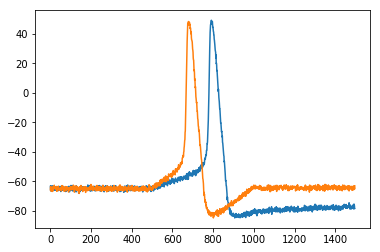

In [15]:
plot(out_trace0)
plot(out_trace1);

In [18]:
out_trace0

array([-63.49704139, -66.29904648, -66.08365952, ..., -76.5185996 ,
       -78.31791415, -78.46495228])

In [19]:
inp_trace0

array([[0., 0., 0., ..., 0., 0., 0.]])

In [16]:
inp_trace = np.concatenate((inp_trace0, inp_trace1))
inp_trace

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
out_trace = np.concatenate(([out_trace0], [out_trace1]))
out_trace

array([[-63.49704139, -66.29904648, -66.08365952, ..., -76.5185996 ,
        -78.31791415, -78.46495228],
       [-65.79207777, -63.60264175, -63.74267379, ..., -64.28441493,
        -65.36354971, -63.18389474]])